# Pattern Recognition and Machine Learning, Lab Assignment – 02

## Install package

In [1]:
!pip install torchtext
!pip install underthesea
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import emoji
import re
import os
import torch
from torch.utils.data import Dataset

## Data Exploration

In [4]:
def Analyze_data(path, type="train"):
  data=pd.read_excel(path)

  emotion_frequency = data["Emotion"].value_counts().reset_index()
  emotion_frequency.columns = ["Emotion", "Frequency"]
  print(emotion_frequency)
  data= data.iloc[:,1:]

  # sns.set()
  data.Emotion.value_counts().plot.bar()
  plt.title(type)
  plt.show()

     Emotion  Frequency
0  Enjoyment       1558
1    Disgust       1071
2      Other       1021
3    Sadness        947
4      Anger        391
5       Fear        318
6   Surprise        242


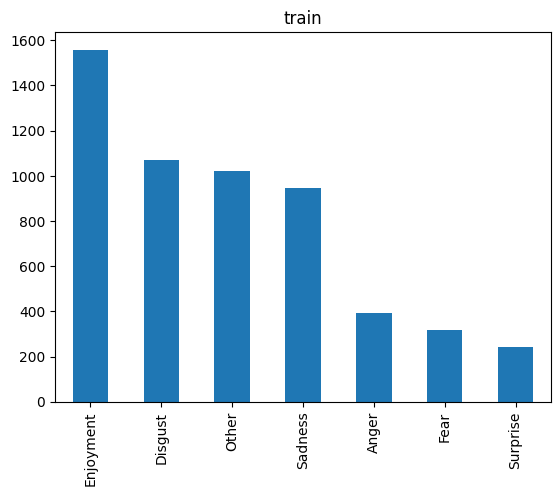

In [5]:
url_train="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/train_nor_811.xlsx"
Analyze_data(url_train)

     Emotion  Frequency
0  Enjoyment        214
1      Other        141
2    Disgust        135
3    Sadness         86
4      Anger         49
5       Fear         31
6   Surprise         30


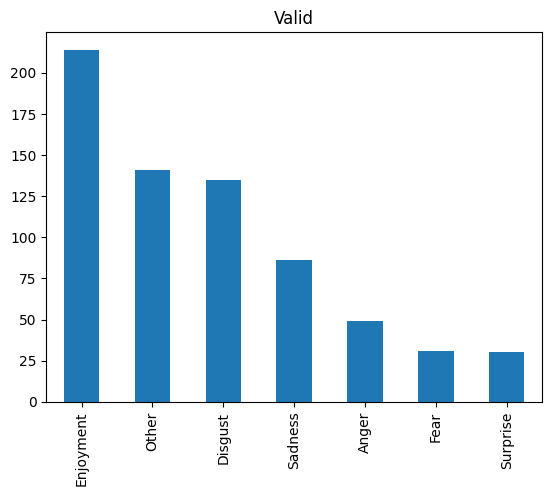

In [6]:
url_train="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/valid_nor_811.xlsx"
Analyze_data(url_train,type="Valid")

     Emotion  Frequency
0  Enjoyment        193
1    Disgust        132
2      Other        129
3    Sadness        116
4       Fear         46
5      Anger         40
6   Surprise         37


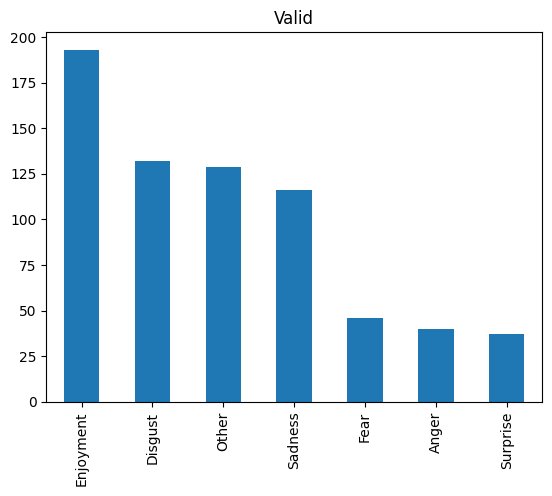

In [7]:
url_train="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/test_nor_811.xlsx"
Analyze_data(url_train,type="Valid")

## Data Preparation

### Transfer Learning

In [8]:
import torch
from tqdm import tqdm
from underthesea import word_tokenize

class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert
        text to numbers and vice versa.
    """

    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def lookup_tokens(self, word_indexes: list):
        """
        @param word_indexes (list(int))
        @return words (list(str))
        """
        return [self.id2word[word_index] for word_index in word_indexes]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @return tokenized_corpus (list(list(str))): list of words
        """
        print("Tokenize the corpus...")
        tokenized_corpus = list()
        for document in tqdm(corpus):
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        """ Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tqdm(tokenized_corpus):
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)), dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        """ Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tqdm(tensor):
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus


In [9]:
import torch
from torchtext.vocab import Vectors

def get_pretrained_word2vec(fpath):
    return Vectors(name=fpath, unk_init=torch.Tensor.normal_)

def create_vocab_from_word2vec(word_embedding):
    vocab = Vocabulary()
    words_list = list(word_embedding.stoi.keys())
    for word in words_list:
        vocab.add(word)
    return vocab

In [10]:
##Load Word2vec 300 dim
# word_embeddings = get_pretrained_word2vec('/content/drive/MyDrive/Pattern Recognition/lab02/word2vec_vi_syllables_300dims.txt')
# vocabulary = create_vocab_from_word2vec(word_embeddings)

In [11]:
#Load Word2vec 100 dim
word_embeddings = get_pretrained_word2vec('/content/drive/MyDrive/Pattern Recognition/lab02/word2vec_vi_words_100dims.txt')
vocabulary = create_vocab_from_word2vec(word_embeddings)

100%|██████████| 1587507/1587507 [01:30<00:00, 17508.75it/s]


### Prepara Data

In [12]:
# Xử lý các emoji trùng gần nhau trong chuỗi
# Ex: "😄😄😄😄" -> "😄"
def remove_duplicate_emoji(string_list):
    normalized_list = []

    for original_string in string_list:

      prev_emoji = None
      remove_duplicate_emoji = []
      for c in original_string:
        if c in emoji.EMOJI_DATA: #emoji.UNICODE_EMOJI_ENGLISH:
            if prev_emoji == c:
                continue
            prev_emoji = c
        remove_duplicate_emoji.append(c)
      normalized_list.append("".join(remove_duplicate_emoji))
    return normalized_list


In [13]:
## Xử lý các icon trong chuỗi. Ex: ":))))"-> ":)"
def normalize_strings(string_list):
    normalized_list = []
    for original_string in string_list:
        # Sử dụng biểu thức chính quy để thay thế nhiều dấu `)` liên tiếp bằng một ký hiệu `)`
        normalized_string = re.sub(r'\)+', ')', original_string)
        normalized_string = re.sub(r'\(+', '(', normalized_string)
        normalized_string = re.sub(r'\>+', '>', normalized_string)
        normalized_string = re.sub(r'\=+', '=', normalized_string)
        normalized_string = re.sub(r'\:+', ':', normalized_string)
        normalized_string = re.sub(r'\?+', '?', normalized_string)
        normalized_string = re.sub(r'\!+', '!', normalized_string)
        # Thêm chuỗi đã chuẩn hóa vào danh sách
        normalized_list.append(normalized_string)

    return normalized_list

In [14]:
##xử lý các từ trong chuỗi có phần kỹ tự của từ bị lặp. Ex: "đâyyyyyy"-> "đây"

def remove_duplicate_chars(input_str):
    if len(input_str) <= 1:
        return input_str

    result_str = input_str[0]
    for i in range(1, len(input_str)):
        if input_str[i] != input_str[i - 1]:
            result_str += input_str[i]

    return result_str

def process_list_of_strings(list_of_strings):
    processed_list = [remove_duplicate_chars(s) for s in list_of_strings]
    return processed_list

In [15]:
## map một số emoji thành từ. Ex: "😄"-> "vui mừng"
emoji_to_vietnamese = {

    "😄": "vui mừng",
    "😂": "cười",
    "😊": "hạnh phúc",
    "😢": "buồn",
    "😍": "ngưỡng mộ",
    "😎": "phong cách",
    "😡": "tức giận",
    "😠": "tức giận",
    "😤": "quạo",
    "😁": "hài lòng",
    "😓": "lo lắng",
    "😇": "thiện chí",
    "😘": "hôn",
    "😰": "lo sợ",
    "😆": "phấn khích",
    "😐": "bình tĩnh",
    "😑": "mặt trơ lời",
    "😏": "nhìn chế",
    "🤔": "nghi ngờ",
    "😷": "ốm",
    "🤢": "buồn nôn",
    "🤣": "cười",
    "🤮": "ói",
    "😭": "khóc"
}


def emoji_to_vietnamese_word(text):
    words = text.split()
    translated_words = [emoji_to_vietnamese.get(word, word) for word in words]
    return " ".join(translated_words)

def process_emoji(list_str):
  processed_list = [emoji_to_vietnamese_word(s) for s in list_str]
  return processed_list

In [16]:

import re
import sys
## Xóa các emoji sau khi map một số các emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def process_emoji2(list_str):
  processed_list = [remove_emoji(s) for s in list_str]
  return processed_list

In [17]:
## Map một số ký tự thích hợp với Word2vec
dict_map = {"òa": "oà","Òa": "Oà","ÒA": "OÀ","óa": "oá","Óa": "Oá","ÓA": "OÁ","ỏa": "oả","Ỏa": "Oả",
    "ỎA": "OẢ","õa": "oã","Õa": "Oã","ÕA": "OÃ","ọa": "oạ","Ọa": "Oạ","ỌA": "OẠ","òe": "oè","Òe": "Oè","ÒE": "OÈ",
    "óe": "oé","Óe": "Oé","ÓE": "OÉ","ỏe": "oẻ","Ỏe": "Oẻ","ỎE": "OẺ","õe": "oẽ","Õe": "Oẽ",
    "ÕE": "OẼ","ọe": "oẹ","Ọe": "Oẹ","ỌE": "OẸ","ùy": "uỳ","Ùy": "Uỳ","ÙY": "UỲ","úy": "uý",
    "Úy": "Uý","ÚY": "UÝ","ủy": "uỷ","Ủy": "Uỷ","ỦY": "UỶ","ũy": "uỹ","Ũy": "Uỹ","ŨY": "UỸ","ụy": "uỵ",
    "Ụy": "Uỵ","ỤY": "UỴ",
    }

def replace_all(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text
def replace_list(list_str):
  processed_list = [replace_all(s,dict_map) for s in list_str]
  return processed_list

In [19]:

def load_dataset(data_dir):

    df=pd.read_excel(data_dir)

    labels=list(df["Emotion"])
    sents=list(df["Sentence"])

    #Xử lý các chuỗi

    #Xử lý dấu (\,/,?,~)
    sents=replace_list(sents)

    #xử lý icon dư dấu ngoặc
    sents=normalize_strings(sents)

    # xử lý các  emoji gần nhau giống nhau
    sents=remove_duplicate_emoji(sents)

    #xử lý các chuỗi bị lặp ký tự
    sents=process_list_of_strings(sents)

    #map các emoji thành word
    sents=process_emoji(sents)

    #xóa các emoji chưa map được
    sents=process_emoji2(sents)

    return sents, labels

In [20]:


class UITVSMECDataset(Dataset):
    def __init__(self, vocab, fpath=None, tokenized_fpath=None):
        """
        @param vocab (Vocabulary)
        @param txt_fpath (str)
        @param tokenized_fpath (str)
        """
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]

        self.sentences,_ = load_dataset(fpath)
        _,self.sentiments = load_dataset(fpath)

        sentiments_type = list(set(self.sentiments))
        sentiments_type.sort()

        self.sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments_type)}

        if tokenized_fpath:
            self.tokenized_sentences = torch.load(tokenized_fpath)
        else:
            self.tokenized_sentences = self.vocab.tokenize_corpus(self.sentences)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_sentences, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments],
                                          dtype=torch.long)

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        feedbacks = [e[0] for e in examples]
        # padding tokens
        feedbacks = torch.nn.utils.rnn.pad_sequence(feedbacks,
                                                    batch_first=True,
                                                    padding_value=self.pad_idx)

        feedback_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"inputs": (feedbacks, feedback_lengths), "labels": sentiments}

In [21]:
train_dataset = UITVSMECDataset(vocab=vocabulary, fpath="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/train_nor_811.xlsx")
test_dataset = UITVSMECDataset(vocab=vocabulary, fpath="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/test_nor_811.xlsx")
val_dataset = UITVSMECDataset(vocab=vocabulary, fpath="/content/drive/MyDrive/Pattern Recognition/lab02/Homework/valid_nor_811.xlsx")

Tokenize the corpus...


100%|██████████| 5548/5548 [00:00<00:00, 90993.34it/s]


Tokenize the corpus...


100%|██████████| 693/693 [00:00<00:00, 58250.72it/s]


Tokenize the corpus...


100%|██████████| 686/686 [00:00<00:00, 49661.58it/s]


### Data loader

In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=test_dataset.collate_fn)

In [28]:
batch = next(iter(train_dataloader))

In [29]:
batch['inputs'][1]

tensor([43, 39, 27, 25, 21, 18, 17, 17, 16, 16, 16, 16, 15, 14, 14, 13, 12, 12,
        11, 10, 10, 10,  9,  9,  9,  8,  7,  7,  5,  4,  4,  4])

In [30]:
batch['labels']

tensor([0, 0, 5, 5, 0, 2, 1, 3, 5, 4, 2, 0, 4, 2, 5, 3, 1, 6, 2, 4, 3, 3, 6, 1,
        1, 1, 4, 4, 2, 4, 2, 2])

##  Build an RNN Model

In [31]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_labels, bidirectional, dropout, pad_idx):
        """
        @param vocab_size (int)
        @param embedding_dim (int)
        @param hidden_dim (int)
        @param n_layers (int)
        @param n_labels (int)
        @param bidirectional (bool)
        @param dropout (float)
        @param pad_idx (int)
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx) # embedding layer
        self.bn = nn.BatchNorm1d(embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_labels)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        """
        @param text (torch.Tensor): shape = [batch_size, seq_len]
        """
        embeds = self.embedding(text) # (bsz, seq_len, hidden_dim)
        bn_embeds = self.bn(embeds.permute(0,2,1)).permute(0,2,1) # batchnorm1d requires input shape (bsz, hidden_dim, seq_len)
        # bn_embeds = self.dropout(bn_embeds)

        output, (hidden, cell) = self.lstm(bn_embeds.permute(1,0,2)) # (C, B, H)
        last_hidden = output[-1] # 1,....,T
        last_hidden = self.dropout(last_hidden)
        return self.fc(last_hidden)

In [32]:
def get_model(vocab, word_embedding, embedding_dim, hidden_dim, n_layers, n_labels, bidirectional, dropout, device=None):
    input_dim = word_embedding.vectors.shape[0]
    pad_idx = vocab["<pad>"]
    unk_idx = vocab["<unk>"]

    model = LSTM(input_dim, embedding_dim, hidden_dim,  n_layers, n_labels, bidirectional, dropout, pad_idx)

    # load pretrained word embeddings
    model.embedding.weight.data.copy_(word_embedding.vectors)

    # Đóng băng trọng số lớp embedding
    # model.embedding.weight.requires_grad = False

    model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
    model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    model.to(device)
    return model

## Prepare Train

### Getmodel

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(vocab=vocabulary, word_embedding=word_embeddings, embedding_dim=100,
                  hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.1, device=device)

In [58]:
model

LSTM(
  (embedding): Embedding(1587507, 100, padding_idx=0)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(100, 512, num_layers=2, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=7, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [59]:
def train(model, dataloader, optimizer, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param optimizer (torch.optim)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model"s loss of this epoch
    """
    epoch_loss = 0
    total = 0
    correct = 0

    model.train()

    for batch in (pbar:=tqdm(dataloader)):
        optimizer.zero_grad() # clear the gradient

        # forward pass
        feedbacks, _ = batch["inputs"]
        feedbacks = feedbacks.to(device)
        logits = model(feedbacks)
        labels = batch["labels"].to(device)

        loss = criterion(logits, labels)

        # make prediction
        _, preds = torch.max(logits, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # backward pass and update params
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), accuracy=correct/total)
        epoch_loss += loss.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, correct / total

def evaluate(model, dataloader, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    total = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            feedbacks, _ = batch["inputs"]
            feedbacks = feedbacks.to(device)
            logits = model(feedbacks)
            labels = batch["labels"].to(device)
            loss = criterion(logits, labels)
            _, preds = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            epoch_loss += loss.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, correct / total

### Balanced_weight

In [60]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Do các data không cân bằng nhau thông qua phân tích từ Data Exploration nên
# cần cân bằng các trọng số của các lớp

def balanced_weight():

  train_classes = train_dataset.tensor_label.numpy()
  sentiments_type = list(set(train_classes))
  sentiments_type.sort()
  orig_weights = {idx: (train_classes==idx).sum()/len(train_classes) for idx in sentiments_type}

  ## tính toán trọng số cân bằng cho từng loại nhãn
  class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_classes), y = train_classes)
  class_weights = dict(zip(np.unique(train_classes), class_weights))

  class_weights = [class_weights[i] for i in range(len(class_weights))]
  ## chuyển đổi danh sách trọng số thành tensor PyTorch và đưa nó lên thiết bị (device),
  class_weights = torch.FloatTensor(class_weights).to(device)

  return class_weights

In [61]:
class_weights=balanced_weight()

### Optimal

In [62]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

## Train

### Training

In [63]:
import time

n_epochs=30
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

his_train_loss=list()
his_train_acc= list()
his_val_loss=list()
his_val_acc=list()

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss, train_acc = train(model, train_dataloader, optim, loss_fn, device)
    valid_loss, valid_acc= evaluate(model, val_dataloader, loss_fn, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    his_train_loss.append(train_loss)
    his_train_acc.append(train_acc)
    his_val_loss.append(valid_loss)
    his_val_acc.append(valid_acc)


    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")


100%|██████████| 174/174 [00:14<00:00, 11.62it/s, accuracy=0.161, loss=1.97]


Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 1.939 | Train Acc: 16.06%
	 Val. Loss: 1.905 |  Val. Acc: 31.05%


100%|██████████| 174/174 [00:14<00:00, 11.65it/s, accuracy=0.177, loss=1.92]


Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 1.930 | Train Acc: 17.68%
	 Val. Loss: 1.908 |  Val. Acc: 29.01%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.141, loss=1.77]


Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 1.901 | Train Acc: 14.10%
	 Val. Loss: 1.913 |  Val. Acc: 11.22%


100%|██████████| 174/174 [00:14<00:00, 11.71it/s, accuracy=0.214, loss=1.6]


Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 1.737 | Train Acc: 21.40%
	 Val. Loss: 1.744 |  Val. Acc: 29.01%


100%|██████████| 174/174 [00:14<00:00, 11.70it/s, accuracy=0.319, loss=1.35]


Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 1.497 | Train Acc: 31.89%
	 Val. Loss: 1.783 |  Val. Acc: 28.43%


100%|██████████| 174/174 [00:14<00:00, 11.70it/s, accuracy=0.43, loss=0.761]


Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 1.256 | Train Acc: 43.04%
	 Val. Loss: 1.810 |  Val. Acc: 34.99%


100%|██████████| 174/174 [00:14<00:00, 11.61it/s, accuracy=0.579, loss=0.717]


Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.988 | Train Acc: 57.91%
	 Val. Loss: 1.831 |  Val. Acc: 42.13%


100%|██████████| 174/174 [00:14<00:00, 11.60it/s, accuracy=0.673, loss=0.496]


Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.771 | Train Acc: 67.27%
	 Val. Loss: 1.937 |  Val. Acc: 43.00%


100%|██████████| 174/174 [00:14<00:00, 11.65it/s, accuracy=0.748, loss=0.317]


Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.615 | Train Acc: 74.84%
	 Val. Loss: 1.882 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.812, loss=0.254]


Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 0.482 | Train Acc: 81.16%
	 Val. Loss: 2.079 |  Val. Acc: 47.38%


100%|██████████| 174/174 [00:14<00:00, 11.73it/s, accuracy=0.854, loss=0.13]


Epoch: 11 | Epoch Time: 0m 15s
	Train Loss: 0.378 | Train Acc: 85.40%
	 Val. Loss: 2.409 |  Val. Acc: 45.19%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.901, loss=0.0395]


Epoch: 12 | Epoch Time: 0m 15s
	Train Loss: 0.265 | Train Acc: 90.10%
	 Val. Loss: 2.547 |  Val. Acc: 43.00%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.919, loss=0.0777]


Epoch: 13 | Epoch Time: 0m 15s
	Train Loss: 0.216 | Train Acc: 91.87%
	 Val. Loss: 2.685 |  Val. Acc: 42.86%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.92, loss=0.022]


Epoch: 14 | Epoch Time: 0m 15s
	Train Loss: 0.205 | Train Acc: 91.98%
	 Val. Loss: 2.727 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:14<00:00, 11.70it/s, accuracy=0.943, loss=0.0469]


Epoch: 15 | Epoch Time: 0m 15s
	Train Loss: 0.155 | Train Acc: 94.30%
	 Val. Loss: 3.003 |  Val. Acc: 49.13%


100%|██████████| 174/174 [00:14<00:00, 11.71it/s, accuracy=0.956, loss=0.0149]


Epoch: 16 | Epoch Time: 0m 15s
	Train Loss: 0.125 | Train Acc: 95.58%
	 Val. Loss: 3.091 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:14<00:00, 11.73it/s, accuracy=0.964, loss=0.00667]


Epoch: 17 | Epoch Time: 0m 15s
	Train Loss: 0.102 | Train Acc: 96.38%
	 Val. Loss: 3.213 |  Val. Acc: 46.36%


100%|██████████| 174/174 [00:14<00:00, 11.70it/s, accuracy=0.969, loss=0.0254]


Epoch: 18 | Epoch Time: 0m 15s
	Train Loss: 0.076 | Train Acc: 96.94%
	 Val. Loss: 3.561 |  Val. Acc: 48.54%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.973, loss=0.00182]


Epoch: 19 | Epoch Time: 0m 15s
	Train Loss: 0.069 | Train Acc: 97.28%
	 Val. Loss: 3.654 |  Val. Acc: 47.96%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.977, loss=0.00308]


Epoch: 20 | Epoch Time: 0m 15s
	Train Loss: 0.059 | Train Acc: 97.73%
	 Val. Loss: 3.990 |  Val. Acc: 47.96%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.976, loss=0.0041]


Epoch: 21 | Epoch Time: 0m 15s
	Train Loss: 0.066 | Train Acc: 97.60%
	 Val. Loss: 4.109 |  Val. Acc: 44.61%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.975, loss=0.017]


Epoch: 22 | Epoch Time: 0m 15s
	Train Loss: 0.075 | Train Acc: 97.49%
	 Val. Loss: 3.413 |  Val. Acc: 45.63%


100%|██████████| 174/174 [00:14<00:00, 11.70it/s, accuracy=0.979, loss=0.00105]


Epoch: 23 | Epoch Time: 0m 15s
	Train Loss: 0.061 | Train Acc: 97.86%
	 Val. Loss: 3.616 |  Val. Acc: 47.08%


100%|██████████| 174/174 [00:14<00:00, 11.72it/s, accuracy=0.988, loss=0.00367]


Epoch: 24 | Epoch Time: 0m 15s
	Train Loss: 0.033 | Train Acc: 98.81%
	 Val. Loss: 4.159 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:14<00:00, 11.69it/s, accuracy=0.991, loss=0.000215]


Epoch: 25 | Epoch Time: 0m 15s
	Train Loss: 0.022 | Train Acc: 99.06%
	 Val. Loss: 4.417 |  Val. Acc: 49.56%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.988, loss=0.00061]


Epoch: 26 | Epoch Time: 0m 15s
	Train Loss: 0.035 | Train Acc: 98.81%
	 Val. Loss: 4.014 |  Val. Acc: 48.83%


100%|██████████| 174/174 [00:14<00:00, 11.67it/s, accuracy=0.981, loss=0.344]


Epoch: 27 | Epoch Time: 0m 15s
	Train Loss: 0.053 | Train Acc: 98.07%
	 Val. Loss: 4.092 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.982, loss=0.00119]


Epoch: 28 | Epoch Time: 0m 15s
	Train Loss: 0.054 | Train Acc: 98.22%
	 Val. Loss: 3.835 |  Val. Acc: 45.92%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.987, loss=0.000826]


Epoch: 29 | Epoch Time: 0m 15s
	Train Loss: 0.035 | Train Acc: 98.70%
	 Val. Loss: 4.188 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:14<00:00, 11.68it/s, accuracy=0.988, loss=0.000399]


Epoch: 30 | Epoch Time: 0m 15s
	Train Loss: 0.032 | Train Acc: 98.77%
	 Val. Loss: 4.229 |  Val. Acc: 47.08%


### Visualize After Training

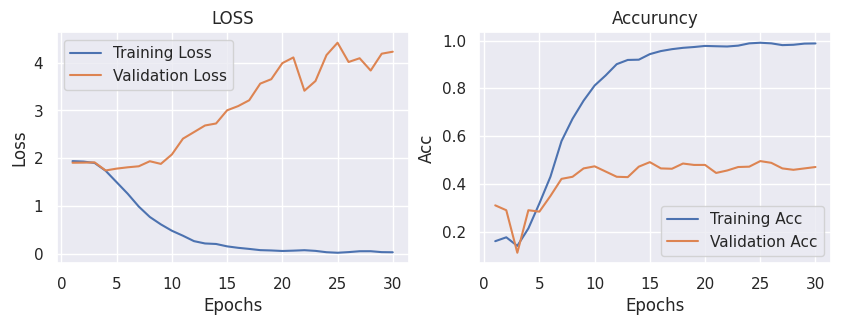

In [64]:
    import seaborn as sns

    sns.set()
    plt.figure(figsize=(10,3))
    epochs = range(1, n_epochs + 1)

    plt.subplot(1,2,1)
    plt.plot(epochs, his_train_loss, label='Training Loss')
    plt.plot(epochs, his_val_loss, label='Validation Loss')
    plt.title("LOSS")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()



    plt.subplot(1,2,2)
    plt.plot(epochs, his_train_acc, label='Training Acc')
    plt.plot(epochs, his_val_acc, label='Validation Acc')
    plt.title("Accuruncy")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

### Save model

In [89]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Pattern Recognition/lab02/model.pt")

## load model
# model.load_state_dict(torch.load('/content/drive/MyDrive/Pattern Recognition/lab02/model.pt'))

## Evaluation

### Evaluate the trained model on the testing set

In [65]:
test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 4.036 | Test Acc: 48.77%


###  Report accuracy, precision, recall, and F1 score

In [66]:

y_pred=[]
y_true=[]

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        feedbacks, _ = batch["inputs"]
        feedbacks = feedbacks.to(device)

        logits = model(feedbacks)
        labels = batch["labels"].to(device)

        _, preds = torch.max(logits, dim=1)

        y_pred+=(list(preds.to('cpu').detach().numpy()))
        y_true += list(labels.to('cpu').detach().numpy())

In [67]:
from sklearn.metrics import classification_report

target_names = ['Anger','Disgust','Enjoyment','Fear','Other','Sadness','Surprise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Anger       0.26      0.28      0.27        40
     Disgust       0.39      0.48      0.43       132
   Enjoyment       0.68      0.57      0.62       193
        Fear       0.60      0.57      0.58        46
       Other       0.38      0.43      0.41       129
     Sadness       0.51      0.52      0.51       116
    Surprise       0.52      0.32      0.40        37

    accuracy                           0.49       693
   macro avg       0.48      0.45      0.46       693
weighted avg       0.50      0.49      0.49       693



### Analyze any misclassifications

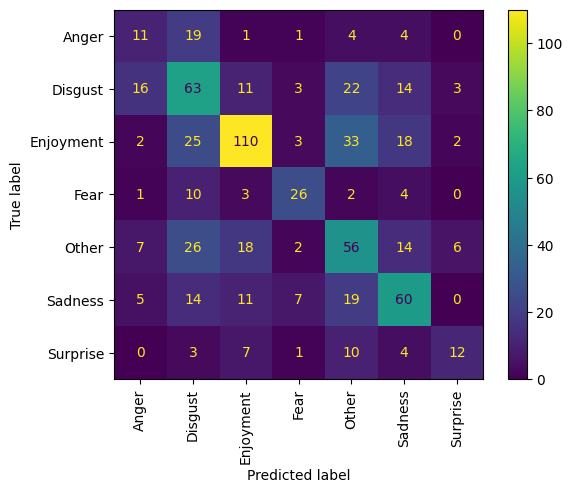

In [70]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


dic_label = {0:'Anger',
            1:'Disgust',
             2:'Enjoyment',
             3:'Fear',
             4:'Other',
             5:'Sadness',
             6:'Surprise'}
y1_true=[dic_label.get(item, item) for item in y_true]
y1_pred=[dic_label.get(item, item) for item in y_pred]
sns.reset_defaults()
cm = confusion_matrix(y1_true, y1_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(xticks_rotation='vertical')
plt.show()

Dựa vào confusion matrix ta có thể thấy được rằng Việc khó khăn trong việc phân biệt một số label với nhau. Chẳn hạn như "Anger" và "Disgust" có mức độ nhầm lẫn với nhau cao, trong khi "Anger" thì chỉ có dự đoán đúng là 11, mà lại nhầm lẫn với "Disgust" là 16. Bởi vì "Anger" và "Disgust" có các đặc điểm tưởng đồng với nhau. Bên cạnh đó cũng còn nhiều các label nhầm lẫn với nhau: "Enjoyment" với "Other",.... Bên cạnh đó việc không cân bằng data của các labels cũng ảnh hưởng đến kết quả.

Model đã bị overfitting.

Kết quả chưa thật sự tốt do bị ảnh hưởng nhiều yếu tố từ tập dữ liệu:
  - Về các label của dữ liệu:
      + Sự tương đồng đặc điểm của các lớp:  'Disgust','Fear','Anger' (hay là  'Enjoyment', 'Surprise')  khiến cho khó khăn trong việc train/evaluate của model. ví dụ:["công nhận sáng tạo thật đấy","Enjoyment"] phân biệt giữa label "Enjoyment" và  "Surprise" thì thật sự khó khăn.
  - Về số lượng: Deep learning thì cần số lượng lớn dữ liệu để train, nhưng tập dữ liệu này được xem là ít.

  - Về chất lượng của data: Label của data chưa thật sự tốt khi việc đánh label của data có nhiều sai sót. Và không cân bằng của các label

Bên cạnh đó cũng có nguyên nhân về cấu trúc model chưa thật sự tốt, hoặc dùng các transfer learning chưa hiệu quả. Theo [paper_UIT_VSMEC](https://paperswithcode.com/paper/a-simple-and-efficient-ensemble-classifier/review/). khi dùng BiLSTM+ Word2vec300 thì F1 là 56.16%. Trong khi mô hình cài đặt BiLSTM+ Word2vec100 Acc: ~49%.

## Hyperparameter

In [100]:

# Hyperparameter Tuning Bacsic
learning_rates = [1e-4, 1e-3, 5e-3]
num_layers_values = [2, 3]
hidden_units_values = [128,256]
dropout_values = [0.3, 0.5]
n_epochs=10
best_accuracy = 0.0
best_hyperparameters = {}

for lr in learning_rates:
    for num_layers in num_layers_values:
        for hidden_units in hidden_units_values:
            for dropout in dropout_values:

              model = get_model(vocab=vocabulary, word_embedding=word_embeddings, embedding_dim=100,
                    hidden_dim=hidden_units, n_layers=num_layers, n_labels=7, bidirectional=True, dropout=dropout, device=device)
              class_weights=balanced_weight()

              optim = torch.optim.AdamW(model.parameters(), lr=lr)
              loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
              print("___"*20)
              print(f"\t Lr: {lr}|num_layers: {num_layers}  | hidden_units: {hidden_units}|dropout:{dropout} ")
              for epoch in range(n_epochs):
                  start_time = time.time()
                  train_loss, train_acc = train(model, train_dataloader, optim, loss_fn, device)
                  valid_loss, valid_acc= evaluate(model, val_dataloader, loss_fn, device)
                  end_time = time.time()

                  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                  print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
                  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
                  print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

              test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
                # Print and store results
              print(f'Hyperparameters: Learning Rate={lr}, Num Layers={num_layers}, Hidden Units={hidden_units}, Dropout={dropout}')
              print(f'Test Accuracy: {test_acc:.4f}')

              if test_acc > best_accuracy:
                  best_accuracy = test_acc
                  best_hyperparameters = {
                      'learning_rate': lr,
                      'num_layers': num_layers,
                      'hidden_units': hidden_units,
                      'dropout': dropout
                  }



____________________________________________________________
	 Lr: 0.0001|num_layers: 2  | hidden_units: 128|dropout:0.3 


100%|██████████| 174/174 [00:11<00:00, 14.76it/s, accuracy=0.187, loss=1.91]


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.945 | Train Acc: 18.67%
	 Val. Loss: 1.937 |  Val. Acc: 22.59%


100%|██████████| 174/174 [00:11<00:00, 15.10it/s, accuracy=0.199, loss=1.93]


Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.938 | Train Acc: 19.92%
	 Val. Loss: 1.920 |  Val. Acc: 21.57%


100%|██████████| 174/174 [00:11<00:00, 14.96it/s, accuracy=0.203, loss=1.95]


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.926 | Train Acc: 20.31%
	 Val. Loss: 1.913 |  Val. Acc: 21.87%


100%|██████████| 174/174 [00:11<00:00, 15.01it/s, accuracy=0.196, loss=1.84]


Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.911 | Train Acc: 19.57%
	 Val. Loss: 1.875 |  Val. Acc: 12.83%


100%|██████████| 174/174 [00:12<00:00, 14.02it/s, accuracy=0.132, loss=1.82]


Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 1.861 | Train Acc: 13.16%
	 Val. Loss: 1.847 |  Val. Acc: 10.35%


100%|██████████| 174/174 [00:12<00:00, 14.34it/s, accuracy=0.131, loss=1.75]


Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 1.784 | Train Acc: 13.12%
	 Val. Loss: 1.815 |  Val. Acc: 12.54%


100%|██████████| 174/174 [00:12<00:00, 14.34it/s, accuracy=0.168, loss=1.69]


Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 1.716 | Train Acc: 16.76%
	 Val. Loss: 1.815 |  Val. Acc: 13.85%


100%|██████████| 174/174 [00:11<00:00, 15.10it/s, accuracy=0.183, loss=1.67]


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.663 | Train Acc: 18.33%
	 Val. Loss: 1.835 |  Val. Acc: 14.58%


100%|██████████| 174/174 [00:11<00:00, 15.22it/s, accuracy=0.238, loss=1.53]


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.574 | Train Acc: 23.76%
	 Val. Loss: 1.863 |  Val. Acc: 15.60%


100%|██████████| 174/174 [00:11<00:00, 15.18it/s, accuracy=0.28, loss=1.43]


Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 1.512 | Train Acc: 28.01%
	 Val. Loss: 1.893 |  Val. Acc: 15.45%
Hyperparameters: Learning Rate=0.0001, Num Layers=2, Hidden Units=128, Dropout=0.3
Test Accuracy: 0.1804
____________________________________________________________
	 Lr: 0.0001|num_layers: 2  | hidden_units: 128|dropout:0.5 


100%|██████████| 174/174 [00:11<00:00, 15.07it/s, accuracy=0.192, loss=1.9]


Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.944 | Train Acc: 19.18%
	 Val. Loss: 1.938 |  Val. Acc: 22.01%


100%|██████████| 174/174 [00:11<00:00, 15.09it/s, accuracy=0.219, loss=1.89]


Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.940 | Train Acc: 21.86%
	 Val. Loss: 1.927 |  Val. Acc: 22.16%


100%|██████████| 174/174 [00:11<00:00, 15.16it/s, accuracy=0.214, loss=1.89]


Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.931 | Train Acc: 21.36%
	 Val. Loss: 1.914 |  Val. Acc: 22.16%


100%|██████████| 174/174 [00:11<00:00, 15.18it/s, accuracy=0.19, loss=1.82]


Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.925 | Train Acc: 18.98%
	 Val. Loss: 1.910 |  Val. Acc: 20.70%


100%|██████████| 174/174 [00:11<00:00, 15.09it/s, accuracy=0.174, loss=1.88]


Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 1.908 | Train Acc: 17.43%
	 Val. Loss: 1.912 |  Val. Acc: 21.87%


100%|██████████| 174/174 [00:11<00:00, 14.89it/s, accuracy=0.15, loss=1.81]


Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 1.876 | Train Acc: 15.00%
	 Val. Loss: 1.870 |  Val. Acc: 10.35%


100%|██████████| 174/174 [00:11<00:00, 14.95it/s, accuracy=0.121, loss=1.89]


Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 1.845 | Train Acc: 12.08%
	 Val. Loss: 1.860 |  Val. Acc: 9.77%


100%|██████████| 174/174 [00:11<00:00, 15.17it/s, accuracy=0.146, loss=1.69]


Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.812 | Train Acc: 14.64%
	 Val. Loss: 1.856 |  Val. Acc: 10.35%


100%|██████████| 174/174 [00:11<00:00, 15.04it/s, accuracy=0.143, loss=1.77]


Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.803 | Train Acc: 14.28%
	 Val. Loss: 1.868 |  Val. Acc: 9.33%


100%|██████████| 174/174 [00:11<00:00, 15.10it/s, accuracy=0.189, loss=1.63]


Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 1.762 | Train Acc: 18.89%
	 Val. Loss: 1.855 |  Val. Acc: 10.35%
Hyperparameters: Learning Rate=0.0001, Num Layers=2, Hidden Units=128, Dropout=0.5
Test Accuracy: 0.1212
____________________________________________________________
	 Lr: 0.0001|num_layers: 2  | hidden_units: 256|dropout:0.3 


100%|██████████| 174/174 [00:12<00:00, 14.08it/s, accuracy=0.164, loss=1.92]


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.943 | Train Acc: 16.42%
	 Val. Loss: 1.925 |  Val. Acc: 22.16%


100%|██████████| 174/174 [00:13<00:00, 13.34it/s, accuracy=0.19, loss=1.86]


Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 1.927 | Train Acc: 19.03%
	 Val. Loss: 1.910 |  Val. Acc: 21.14%


 91%|█████████ | 158/174 [00:11<00:01, 14.17it/s, accuracy=0.145, loss=1.99]


KeyboardInterrupt: ignored

**Do Vấn Đề Tài Nguyên Không Thể chạy một lần nên phải dùng nhiều tài nguyên khác nhau để train và Nâng Cao hơn trong việc tuning sau đó rút trích ra bảng tóm tắt**



|Model|Num_epochs|freeze Embedding|hidden_dim| n_layers|dropout|Test Accuruncy|
|--|--|--|--|--|--|--|
|BiLSTM+ Word2vec100|20|False|800|2|0.5|47.62|
|BiLSTM+ Word2vec100|20|False|512|2|0.1|48.77|
|BiLSTM+ Word2vec100|20|False|215|2|0.5|45.74|
|BiLSTM+ Word2vec100|10|False|215|2|0.75|44.01|
|BiLSTM+ Word2vec100|10|False|512|2|0.75|38.53|
|BiLSTM+ Word2vec100|10|True|215|2|0.5|15.08|
|BiLSTM+ Word2vec100|10|True|215|2|0.1|35.93|
|BiLSTM+ Word2vec100|10|True|512|2|0.1|36.08|
|BiLSTM+ Word2vec100|10|True|512|2|0.5|26.26|
|BiLSTM+ Word2vec100|10|False|215|3|0.5|46.09|
|BiLSTM+ Word2vec100|10|False|512|3|0.5|39.54|
|BiLSTM+FastText|10|False|256|2|0.4|45.34|
|BiLSTM+FastText|10|False|256|3|0.2|47.01|
|LSTM+Word2vec|20|False|512|2|0.4|44.73|
|LSTM+Word2vec|20|False|128|3|0.4|40.12|











Thông qua quá trình hyperparameter tuning thì có thể thấy rằng việc kết hợp mô hình BiLSTM+ Word2vec/FastText thì có thể làm cho val/test có acc là gần 50%. Khi đóng băng lớp embedding(không cập nhật trọng số cho embedding layer) thì model có vẻ không được tốt. Số Chiều hidden layer cao quá tốn khá nhiều thời gian để train nhưng kết quả cũng không khả quan hơn hẳn. Model đang gặp phải vấn đề Overfitting nên cần phải cho nó đơn giản không nên quá phức tạp. Cùng một tập các siêu tham số nhưng các lần chạy khác nhau cho kết quả khác nhau chênh lệch nhưng không quá 3% nguyên do là mỗi lần train thì trọng số khởi tạo sẽ khác nhau do đó dẫn đến việc khác nhau.

## Predict

In [ ]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = get_model(vocab=vocabulary, word_embedding=word_embeddings, embedding_dim=100,
#                   hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.1, device=device)

# model.load_state_dict(torch.load('/content/drive/MyDrive/Pattern Recognition/lab02/model.pt'))

In [97]:
def predict(model, vocab, device, input_text):
    model.eval()
    model.to(device)

    sents=replace_list([input_text])
    sents=normalize_strings(sents)
    sents=remove_duplicate_emoji(sents)
    sents=process_list_of_strings(sents)
    sents=process_emoji(sents)
    sents=process_emoji2(sents)
    input_text=sents[0]

    tokens = vocab.corpus_to_tensor([input_text])[0].view(1,-1)
    tokens = tokens.to(device)
    with torch.no_grad():
        logits = model(tokens)
        _, preds = torch.max(logits, dim=-1)
        print("\n Kết Quả: ",dic_label[ preds.item()])


In [98]:
predict(model, vocabulary, "cuda:0", "Hôm nay trời thật đẹp :)))")

Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 6009.03it/s]


 Kết Quả:  Enjoyment


## Discussion and Analysis

**Các thách thức và hiểu biết trong quá trình thực hiện:**
  - Thách thức:
    + Về tập dữ liệu: Tập dữ liệu được cho thì có số lượng khá ít trong khi dùng deep learning. Bên cạnh đó thì tập dữ liệu không cân bằng giữa các label. Đặc điểm tương đồng để phân biệt giữa các label khá khó. Các từ ngữ trong chuỗi thì sai chính tả, viết tắt,...
    + Về model: Cần tìm hiểu các cấu trúc cần triền khai model (LSTM, BiLSTM, GRU,..), các mô hình pretrain cho tiếng Việt chẳn hạn như (FastText, Word2Vec100/300,..). Chạy thử nhiều lần các model kết hợp với các preTrain.
    + Tài Nguyên: Việc dùng Colab/Kaggle để chạy model thì khá tốn nhiều tài nguyên, và việc giới hạn GPU của Colab/Kaggle cũng gặp nhiều khó khăn.
    + Bị hạn chế trong việc thử kết hợp các model với các transfer với nhau do tốn kém dung lượng, tài nguyên để thử.
  - Hiểu biết đạt được: Sau nhiều khó khăn gặp phải thì đã giúp biết được thêm nhiều kiến thức hay, cách xử lý tốt, linh hoạt trong quá trình dùng GPU. Nắm bắt được quy trình thực hiện triển khai LSTM/BiLSTM/GRU, hiểu biết thêm về một số mô hình có sẵn như FastText, Word2vec100/300,.... Hiểu rõ được các vấn đề cần xử lý với dữ liệu dạng Text.  
      

**Trực quan trong quá trình Training**

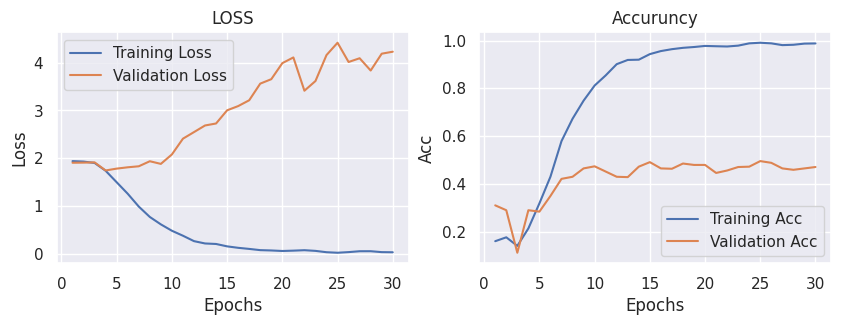

Nhìn vào biểu đồ trên thì model đã bị overfit. Mặc dù thử nhiều cách để tránh Overfit nhưng việc này không thể tránh khỏi dù đã thử nhiều model khác nhau nhưng vẫn không cải thiện. Nguyên nhân như đã nói các mặt khó khăn ở trên.

**Trực Quan Bằng confusion matrices**

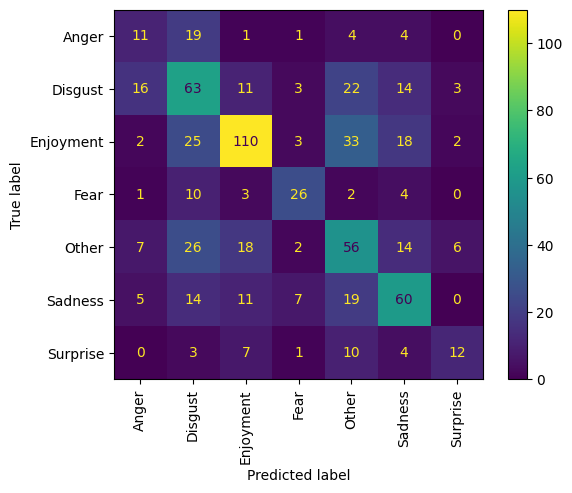

Biểu đồ trên cho biết Model dự đoán khả năng chính xác của từng lớp dựa trên tập Test có sẵn.

**Tầm quan trọng của hyperparameter tuning**

Điều chỉnh siêu tham số đóng vai trò quan trọng trong việc đạt được hiệu suất tốt của mô hình học máy. Siêu tham số là những tham số không phải được học từ dữ liệu mà phải được thiết lập trước quá trình đào tạo.

Có rất nhiều siêu tham số trong quá trình train chẳn hạn như learning rate, số lớp hidden, số lớp layer, số chiều embedding,... Việc hyperparameter tuning giúp ta chọn được các siêu tham số phù hợp với model.

Điều chỉnh siêu tham số giúp tìm ra cấu hình tối ưu nhất cho mô hình. Nếu chúng ta sử dụng các giá trị siêu tham số không phù hợp, mô hình có thể không đạt được hiệu suất tốt nhất hoặc thậm chí không hội tụ.

Siêu tham số cũng đóng vai trò quan trọng trong việc kiểm soát overfitting  và underfitting của mô hình. Chẳng hạn, việc sử dụng các kỹ thuật như dropout có thể giúp ngăn chặn overfitting, nhưng cần được điều chỉnh đúng đắn để tránh gây ra underfitting.

**Các Đề Suất Cải Tiến**

- Về Data Mở rộng dữ liệu nếu có thể để có thêm nhiều data. Thu thập tránh data bị mất cân bằng,..

- Nâng cấp các kỹ thuật xử lý như xử lý các từ viết tắc (vd: "dk" -> "được"), sai vị trí dấu, map tất cả các emoji sang từ,..

- Dùng các model mạnh hơn như BERT, Transformer,.. hoặc kết hợp các model với nhau như: CNN + fastText, GRU + CNN + BiLSTM + LSTM, BERT + CNN + BiLSTM + LSTM,....

**CÁC KẾT QUẢ PHÂN TÍCH**

Kết quả dựa trên tập Test

||precision|recall|f1-score|support|
|--|--|--|--|--|
|Anger |0.26|0.28| 0.27|      40   |
|Disgust  |     0.39   |   0.48    |  0.43   |    132|
|Enjoyment |      0.68   |   0.57    |  0.62   |    193|
|Fear |      0.60    |  0.57     | 0.58  |      46|
 | Other    |   0.38     | 0.43     | 0.41  |     129|
|Sadness  |     0.51      |0.52   |   0.51    |   116|
|Surprise   |    0.52   |   0.32 |     0.40 |       37       |

- Accuracy Test: 48.77 %

Mô hình bị Overfit

**CÁC NỘI DUNG NẮM ĐƯỢC SAU LAB02**

- Biết được thêm các kỹ thuật xử lý Text trước khi huấn luyện.
- Biết cách xử lý data không cân bằng.
- Nắm được quy trình cần triển khai trong lĩnh vực NLP(Natural Languge Processing).
- Triển khai được mô hình RNN cơ bản: RNN, LSTM, BiLSTM, GRU,...
- Biết kết hợp mô hình với một số một số mô hình embedding đã train sẵn: Word2vec100/300, FastText,..

- Trãi Nghiệm được quá trình tuning có kinh nghiệm tốt hơn trong việc điều chỉnh các siêu tham số.
- Nghiên cứu nguyên nhân giải pháp để tránh overfitting
- Biết đánh giá hiệu suất của mô hình RNN trên dữ liệu và tìm hiểu cách hiểu quả mô hình trong việc dự đoán cảm xúc từ các câu văn tiếng Việt. Hiểu rõ hơn về confusion matrices.
- Phát sinh thêm nhiều ý tưởng đối với các cách để cải tiến.


